In [1]:
import torch
import torch.cuda as cuda
from torch.nn.functional import pad
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np
from os.path import exists
from Dataset import FramesDataset
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights


In [8]:
BATCH = 1
EPOCHS = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
model = raft_large(weights=Raft_Large_Weights.C_T_SKHT_K_V1).to(device)
dir_dataset = r'C:\Users\Mau\Desktop\proyectos\Proyecto\test_2k_540p'
dataset = FramesDataset(dir = dir_dataset, transform=transforms.ToTensor())
model.train()

RAFT(
  (feature_encoder): FeatureEncoder(
    (convnormrelu): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (convnormrelu1): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (convnormrelu2): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (downsample): Identity()
        (relu): ReLU(inplace=True)
      )
      (1): ResidualBlock(
        (

In [3]:
length = dataset.__len__()
test = length//10
train = length - test
trainset, testset = random_split(dataset,[train,test])
trainset = DataLoader(trainset, batch_size=BATCH, shuffle=True, pin_memory=True,num_workers=2)
testset = DataLoader(testset, batch_size=1, shuffle=True)
def normData(img):
    w, h = img.shape[2:4]
    img = pad(img, (0,0,w%8,h%8), "constant", 0)
    return img

In [ ]:
if(exists("./weights-RAFT.pth")):
  model.load_state_dict(torch.load('./weights-RAFT.pth'))

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=args.wdecay, eps=args.epsilon)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, args.lr, args.num_steps+100,pct_start=0.05, cycle_momentum=False, anneal_strategy='linear')
for epoch in range(EPOCHS):
    for data in trainset:
        (F1,F3) ,F2, (img1, img3) = data 
        img1 = normData(img1)
        img3 = normData(img3)
        output = model(img1.to(device), img3.to(device))
        del F1, F2, F3, output,  img1, data

In [4]:
(F1,F3) ,F2, (img1, img3) = next(iter(testset))
del F1, F3, F2
cuda.reset_peak_memory_stats(device="cuda")
img1 = normData(img1)
img3 = normData(img3)
with torch.no_grad():
    output = model(img1.to(device), img3.to(device))[0]

In [5]:
flow = np.transpose(output.cpu().numpy()[0], (1,2,0))
frame1 = np.transpose(img1.cpu().numpy()[0], (1,2,0))
frame3 = np.transpose(img3.cpu().numpy()[0], (1,2,0))
print(flow.shape)
print(frame1.shape)

(544, 960, 2)
(544, 960, 3)


In [6]:
flow2 = flow
h, w = flow.shape[:2]
flow = -flow
flow[:,:,0] += np.arange(w)
flow[:,:,1] += np.arange(h)[:,np.newaxis]
newFrame = cv2.remap(frame1, flow,None, cv2.INTER_LINEAR)
hsv = np.zeros(frame1.shape, dtype=np.uint8)
hsv[..., 1] = 0
mag, ang = cv2.cartToPolar(flow2[..., 0], flow2[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

(544, 960, 3)


Text(0.5, 1.0, 'Fotograma 2')

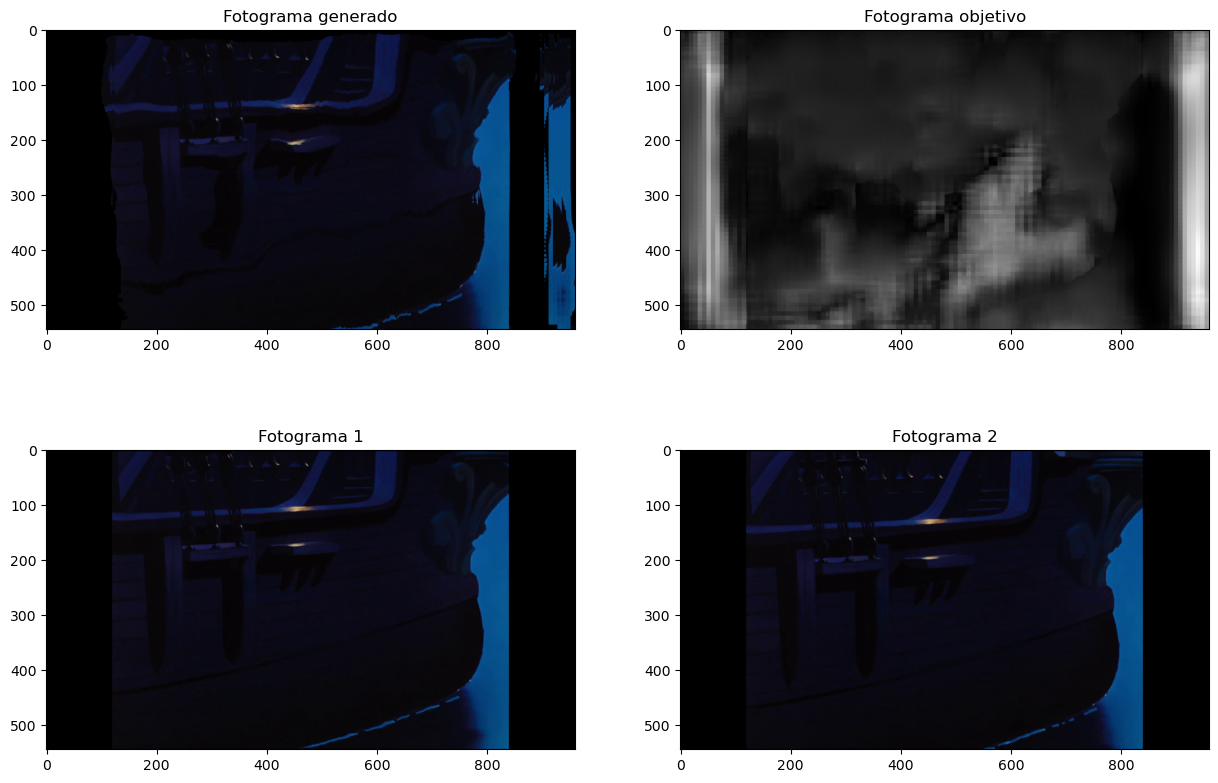

In [7]:
fNew = cv2.cvtColor(newFrame, cv2.COLOR_BGR2RGB)
f1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
f2 = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
f3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)
print(frame1.shape)
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(2, 2, 1)
plt.title("Fotograma generado")
plt.imshow(fNew)
fig.add_subplot(2, 2, 2)
plt.imshow(f2)
plt.title("Fotograma objetivo")
fig.add_subplot(2, 2, 3)
plt.imshow(f1)
plt.title("Fotograma 1")
fig.add_subplot(2, 2, 4)
plt.imshow(f3)
plt.title("Fotograma 2")

In [ ]:
torch.save(model.state_dict(), 'weights-RAFT.pth')